In [30]:
import numpy as np
import tensorflow
import cv2
from pathlib import Path

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

#%matplotlib inline

### Import des Modells

Import des in simple.ipynb mit dem *MNIST* Datensatz trainierten Modells

In [9]:
MODEL = "./cnn_model.keras"
model = load_model(MODEL)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

input_shape = model.input_shape[1:]
print("test", input_shape)
model.summary()

test (28, 28, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        31,370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,026 (195.41 KB)

 Trainable params: 50,026 (195.41 KB)

 Non-trainable params: 0 (0.00 B)

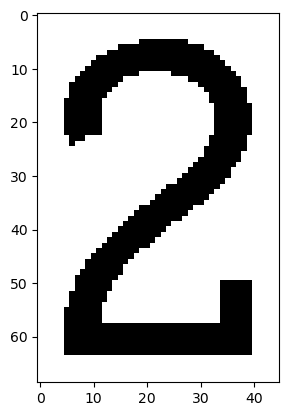

In [10]:
input = "data/fonts/deuce/img.png"
threshold_mode = 0
def collect_data_from_raw(img: str, threshold_mode, save: bool = False) -> list:
    results = []
    image = cv2.imread(img)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_image, cmap='gray')
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY_INV)
    plt.imshow(binary_image, cmap='gray')
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    padding = 5
    i = 0
    threshold_value = 128
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        roi = gray_image[y:y+h, x:x+w]
        padded_roi = np.full((h + 2 * padding, w + 2 * padding), 255, dtype=np.uint8)
        plt.imshow(roi, cmap='gray')
        pad_y_start = padding
        pad_x_start = padding
        padded_roi[pad_y_start:pad_y_start + h, pad_x_start:pad_x_start + w] = roi
        plt.imshow(padded_roi, cmap='gray')
        _, thresholded_image = cv2.threshold(padded_roi, threshold_value, 255, 0)
        plt.imshow(thresholded_image, cmap='gray')

        if save:
            cv2.imwrite(f'zahl_{i}.png', thresholded_image / 255.0)
        i += 1
        results.append(thresholded_image / 255.0) # normalization step
    return results
    
images = collect_data_from_raw(input, 1, save=True)
#plt.imshow(images[0])

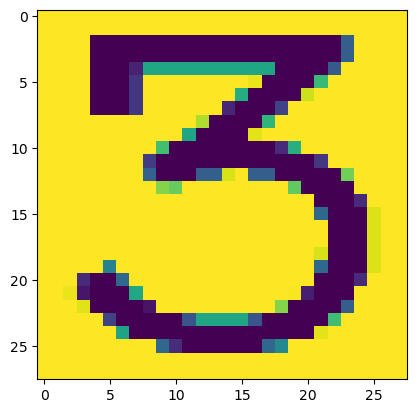

In [11]:
def resize_images(images: list, target_size) -> list:
    return [cv2.resize(image, (target_size[0], target_size[1])) for image in images]

def reshape_images_for_cnn(imageIn: list) -> list:
    return [np.expand_dims(image, axis=-1) for image in imageIn]

def normalize_images(images: list) -> list:
    return [np.array(image) / 255.0 for image in images]

resized_images = resize_images(images, input_shape)
reshaped_images = reshape_images_for_cnn(resized_images)
#normalized_images = normalize_images(reshaped_images)

plt.imshow(reshaped_images[2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2


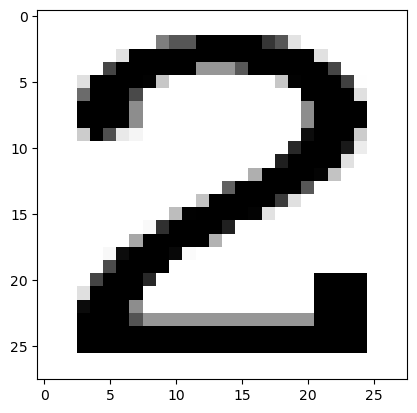

In [12]:
resized_images = resize_images(images, input_shape)

 
    
imag = reshape_images_for_cnn(resized_images)
# print(np.squeeze(imag[0], axis=2).shape)
x = model.predict(np.array(imag, dtype=np.float32))
i = 9
print(np.argmax(x[i]))
plt.imshow(np.squeeze(imag[i], axis=2), cmap='gray')
#print(x)

In [13]:
def plot_images(images, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()

    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')

    # Verstecke die restlichen Achsen, falls es mehr Achsen als Bilder gibt
    for ax in axes[len(images):]:
        ax.axis('off')

    #plt.tight_layout()
    plt.suptitle(f"Font {title}")
    plt.show()

In [14]:
# threshold_mode = 0 normal (schwarze schrift) threshold_mode = 1 invertiert (weiße schrift)
# Funktioniert nicht
def run(order_list, font_name, threshold_mode, target_size, image_path):
    images = collect_data_from_raw(image_path, threshold_mode, True)
    resized_images = resize_images(images, target_size)
    reshaped_images = np.array(reshape_images_for_cnn(resized_images))
    print(reshaped_images[0].shape)
    pred = model.predict(reshaped_images)
    predicted_classes = np.argmax(pred, axis=1)
    print(predicted_classes)
    print(f"""
        Font:                      {font_name}
        Threshold mode:            {threshold_mode}  
        Predicted classes:         {predicted_classes}
        Actual classes:            {order_list}
        Correctly predicted count: {np.sum(predicted_classes == order_list)}
        Wrongly predicted count:   {np.sum(predicted_classes != order_list)}
        Accuracy:                  {np.sum(predicted_classes == order_list) / len(order_list)}
    """)
    plot_images(images, title=f"Font: {font_name}", rows=2, cols=5)
    
    

(28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[1 5 5 1 3 3 3 3 1 2]

        Font:                      Deuce
        Threshold mode:            0  
        Predicted classes:         [1 5 5 1 3 3 3 3 1 2]
        Actual classes:            [7 5 3 1 0 9 8 6 4 2]
        Correctly predicted count: 3
        Wrongly predicted count:   7
        Accuracy:                  0.3
    


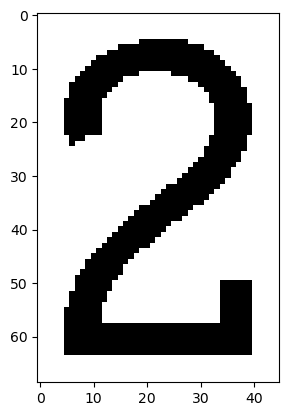

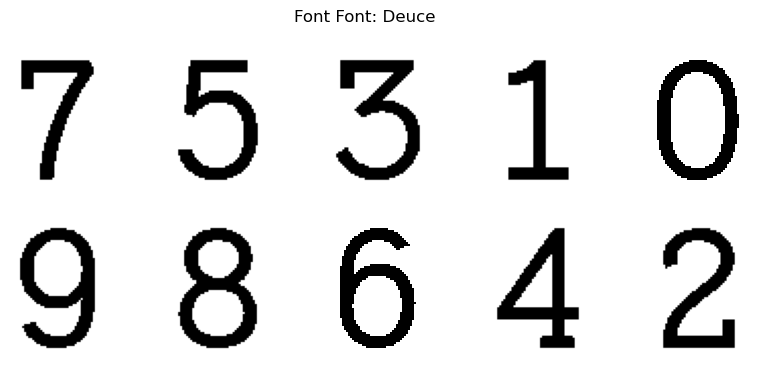

In [15]:
run(np.array([7, 5, 3, 1, 0, 9, 8, 6, 4, 2]), "Deuce", 0, model.input_shape[1:], "data/fonts/deuce/img.png")

(28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[3 3 3 3 5 5 5 3 5 3]

        Font:                      Number Bayside
        Threshold mode:            1  
        Predicted classes:         [3 3 3 3 5 5 5 3 5 3]
        Actual classes:            [9 8 7 6 5 2 1 0 4 3]
        Correctly predicted count: 2
        Wrongly predicted count:   8
        Accuracy:                  0.2
    


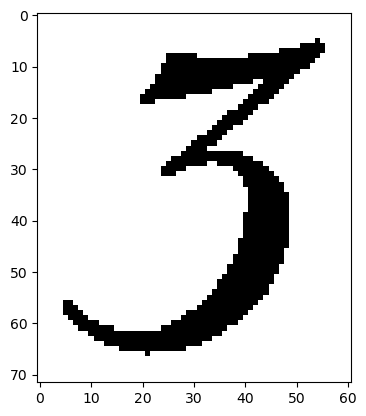

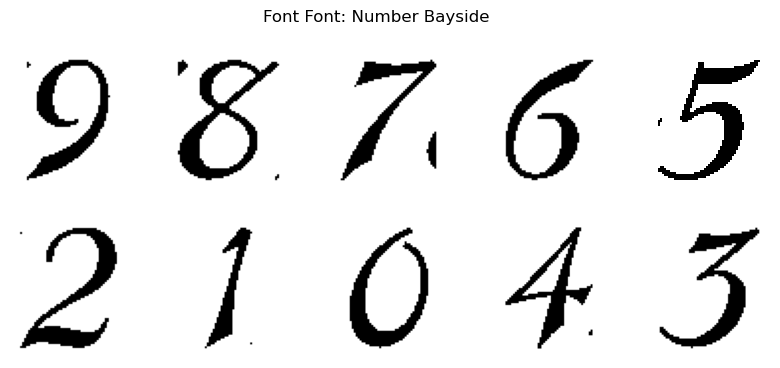

In [16]:
run(np.array([9, 8, 7, 6, 5, 2, 1, 0, 4, 3]), "Number Bayside", 1, model.input_shape[1:], "data/fonts/number_bayside/img.png")


(28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[5 5 1 5 4 5 5 2 5 2]

        Font:                      Number Strasse
        Threshold mode:            1  
        Predicted classes:         [5 5 1 5 4 5 5 2 5 2]
        Actual classes:            [7 5 4 3 1 0 9 8 6 2]
        Correctly predicted count: 2
        Wrongly predicted count:   8
        Accuracy:                  0.2
    


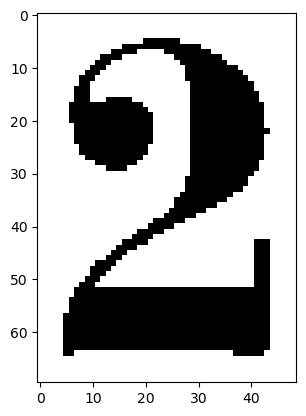

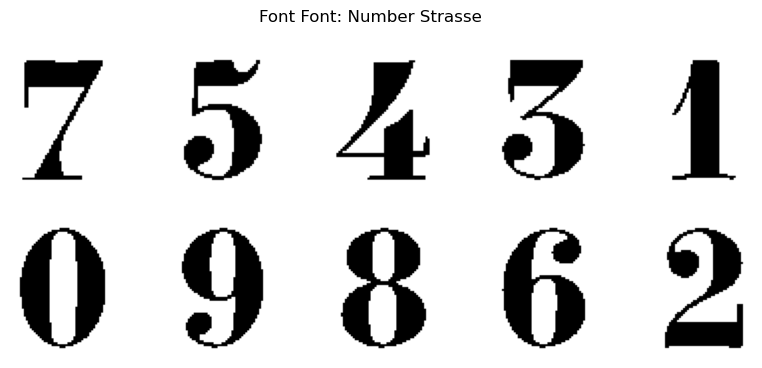

In [17]:
run(np.array([7, 5, 4, 3, 1, 0, 9, 8, 6, 2]), "Number Strasse", 1, model.input_shape[1:], "data/fonts/number_strasse/img.png")

(28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[4 3 5 5 5 5 5 1 5 2]

        Font:                      Numbers Depot
        Threshold mode:            1  
        Predicted classes:         [4 3 5 5 5 5 5 1 5 2]
        Actual classes:            [1 0 9 8 7 6 5 4 3 2]
        Correctly predicted count: 2
        Wrongly predicted count:   8
        Accuracy:                  0.2
    


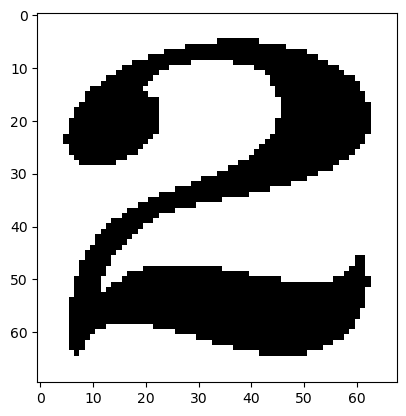

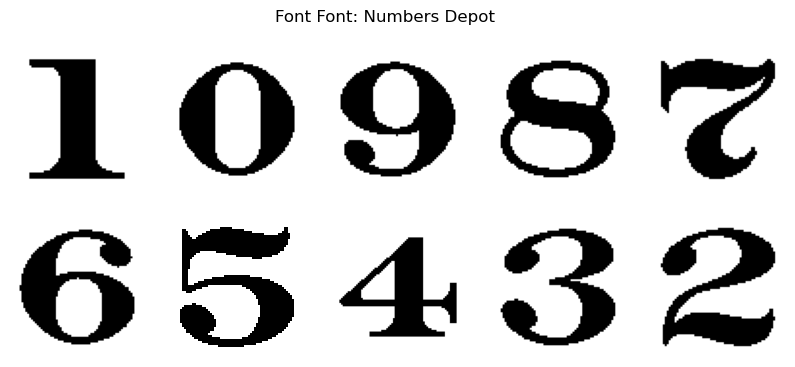

In [18]:
run(np.array([1, 0, 9, 8, 7, 6, 5, 4, 3, 2]), "Numbers Depot", 1, model.input_shape[1:], "data/fonts/numbers_depot/img.png")

(28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[2 5 5 5 2 5 5 1 5 1]

        Font:                      Crash Numbering
        Threshold mode:            1  
        Predicted classes:         [2 5 5 5 2 5 5 1 5 1]
        Actual classes:            [2 9 7 0 8 6 5 4 3 1]
        Correctly predicted count: 3
        Wrongly predicted count:   7
        Accuracy:                  0.3
    


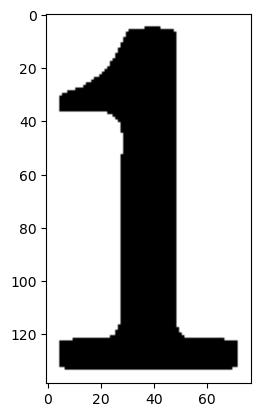

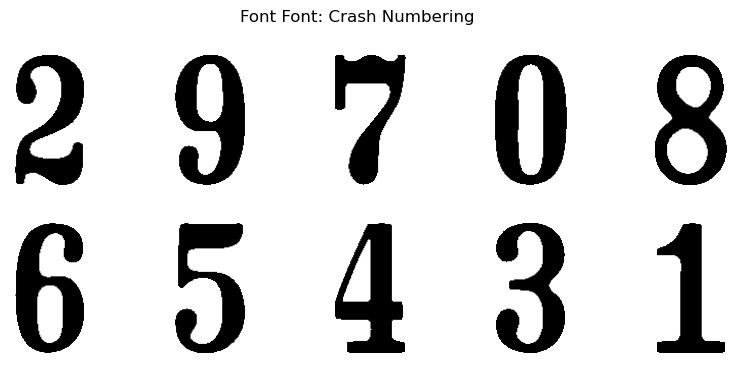

In [19]:
run(np.array([2, 9, 7, 0, 8, 6, 5, 4, 3, 1]), "Crash Numbering", 1, model.input_shape[1:], "data/fonts/crash_numbering/img.png")

In [20]:
#run(np.array([2, 9, 7, 0, 8, 6, 5, 4, 3, 1]), "Lived Mas", 1, model.input_shape[1:], "data/fonts/lived_mas/img.png")
# Lived Mas not suitable for import

(28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[2 5 3 3 2 3 3 5 5 5]

        Font:                      Perfect Garden
        Threshold mode:            1  
        Predicted classes:         [2 5 3 3 2 3 3 5 5 5]
        Actual classes:            [1 7 6 5 2 0 4 9 8 3]
        Correctly predicted count: 1
        Wrongly predicted count:   9
        Accuracy:                  0.1
    


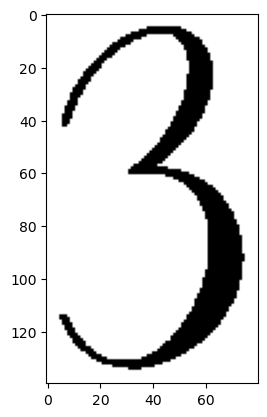

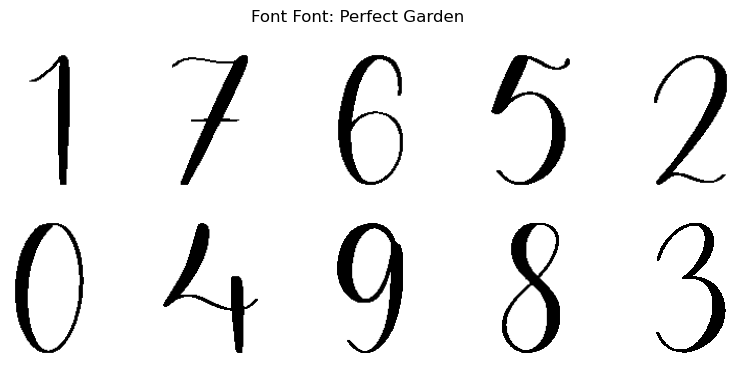

In [21]:
run(np.array([1, 7, 6, 5, 2, 0, 4, 9, 8, 3]), "Perfect Garden", 1, model.input_shape[1:], "data/fonts/perfect_garden/img.png")

In [22]:
import keras
from sklearn.metrics import confusion_matrix
from keras.src.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_test=x_test / 255
Y_test=keras.utils.to_categorical(y_test,10)
X_train=x_train[0:50000] / 255 #divide by 255 so that they are in range 0 to 1
X_train=np.reshape(X_train, (X_train.shape[0],28,28,1))
Y_train=keras.utils.to_categorical(y_train[0:50000],10) # one-hot encoding


X_test=np.reshape(X_test, (X_test.shape[0],28,28,1))

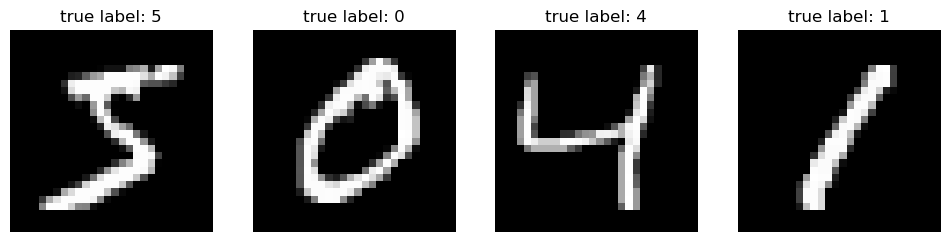

In [23]:
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.array2string(np.argmax(Y_train,axis=1)[i]))
    plt.axis('off')

In [24]:
# Just for validation

pred = model.predict(X_test)
print(confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(pred, axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1) == np.argmax(pred, axis=1)) / len(pred)
print("Acc_fc_orig_flat = ", acc_fc_orig)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[ 978    0    0    1    0    0    0    0    1    0]
 [   0 1129    2    1    0    2    1    0    0    0]
 [   2    0 1025    0    1    0    1    3    0    0]
 [   0    0    1 1002    0    5    0    0    2    0]
 [   0    0    2    0  972    0    1    0    1    6]
 [   2    0    0    4    0  881    3    1    0    1]
 [   6    2    0    0    1    6  942    0    1    0]
 [   0    2    8    2    0    1    0 1013    1    1]
 [   5    0    2    2    1    1    0    2  958    3]
 [   2    3    2    1    5    5    0    3    1  987]]
Acc_fc_orig_flat =  0.9887
